# Template for reading NetCDF files from NSF NCAR Research Data Archive

- Data and model forcings from CESM2 Large Ensemble Project following CMIP6 historical forcings prior to 2015 and SSP3-7.0 forcings thereafter.
- Currently reads 20 member TREFHT/aice/PSL ensembles from select periods for AAER ('only' aerosols evolving with time), 15 members from select periods for GHG ('only' greenhouse gases evolving with time), 10 members from select periods for xAER ('all but' aerosols evolving with time) and 20 members from select periods for LENS (all forcings evolving).
- Data plotted represents (ensemble mean) forcing effect on surface temperature ($T_{s}$) Reference temp height 2m. Also sea ice concentration
- Anomaly (residual) from 1920-40 ensemble avg deduced for all periods measured, to test nonlinearity component for each period
- Non-linearity component (if applicable) deduced by the formula: $AAER-(LENS-\text{x}AER)$

## Code for saving `nonlinear.X` variables as new NetCDF files (to be called later)

In [1]:
pip install cmocean

  Using cached cmocean-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached cmocean-4.0.3-py3-none-any.whl (421 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
### Import packages

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import numpy as np
import matplotlib.path as mpath
import os
import cmocean

In [2]:
# Plot MSLP

def plot_global_maps_mslp(
    dataarrays,
    titles=None,
    cmap="cmocean.delta",      # diverging scheme centered at 0
    vmin=-2, vmax=2,    # small anomaly range (hPa)
    suptitle=None,
    contour_interval=0.25,  # isobar interval (in hPa)
):
    """
    Plot one or more global PSL anomaly maps side-by-side (North Polar projection)
    with isobars (contour lines).

    Parameters
    ----------
    dataarrays : xarray.DataArray or list of DataArrays
        PSL anomaly fields (e.g. differences relative to 1920–1940 baseline).
    titles : list of str or str, optional
        Titles for each subplot.
    cmap : str
        Colormap for anomalies (default: 'RdBu_r').
    vmin, vmax : float
        Color limits for anomaly magnitude (in hPa).
    suptitle : str, optional
        Title for the whole figure.
    contour_interval : float
        Interval between isobars (in hPa).
    """
    # Ensure input is a list
    if not isinstance(dataarrays, (list, tuple)):
        dataarrays = [dataarrays]
    n = len(dataarrays)

    # Handle titles
    if titles is None:
        titles = [""] * n
    elif isinstance(titles, str):
        titles = [titles] * n

    # Create subplots
    fig, axes = plt.subplots(
        1, n,
        figsize=(5 * n, 5),
        subplot_kw={"projection": ccrs.NorthPolarStereo()}
    )

    if n == 1:
        axes = [axes]

    def add_circle_boundary(ax):
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

    for ax, da, title in zip(axes, dataarrays, titles):
        # Ensure units in hPa (convert if needed)
        if da.attrs.get("units", "").lower() == "pa":
            da = da / 100
            da.attrs["units"] = "hPa"

        # Filled contour (anomaly field)
        im = da.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False,
        )

        # Overlay isobars (every contour_interval hPa)
        levels = np.arange(vmin, vmax + contour_interval, contour_interval)
        cs = ax.contour(
            da["lon"], da["lat"], da,
            levels=levels,
            colors="black",
            linewidths=0.6,
            alpha=0.6,
            transform=ccrs.PlateCarree(),
        )
        ax.clabel(cs, fmt="%.1f", fontsize=7)

        # Map details
        ax.coastlines()
        ax.set_extent([-180, 180, 90, 40], crs=ccrs.PlateCarree())
        add_circle_boundary(ax)
        ax.set_title(title, fontsize=12)

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.05, pad=0.07)
    cbar.set_label("Pressure (hPa)")

    # Suptitle
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=1.05)

In [3]:
# Plot temperature

def plot_global_maps(dataarrays, titles=None, cmap="coolwarm", vmin=None, vmax=None, suptitle=None):
    """
    Plot one or more global maps side-by-side (North Polar projection).
    
    Parameters
    ----------
    dataarrays : xarray.DataArray or list of xarray.DataArray
        One or multiple DataArrays to plot.
    titles : list of str or str, optional
        Titles for each subplot. Must match number of dataarrays if list.
    cmap : str
        Colormap name.
    vmin, vmax : float, optional
        Color scale limits.
    """
    # Ensure input is a list
    if not isinstance(dataarrays, (list, tuple)):
        dataarrays = [dataarrays]
    n = len(dataarrays)

    # Handle titles
    if titles is None:
        titles = [""] * n
    elif isinstance(titles, str):
        titles = [titles] * n

    # Create subplots
    fig, axes = plt.subplots(
        1, n,
        figsize=(5 * n, 5),
        subplot_kw={"projection": ccrs.NorthPolarStereo()}
    )

    # Handle single subplot case
    if n == 1:
        axes = [axes]

    def add_circle_boundary(ax):
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

    # Plot each map
    for ax, da, title in zip(axes, dataarrays, titles):
        im = da.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.coastlines()
        ax.set_extent([-180, 180, 90, 40], crs=ccrs.PlateCarree())
        add_circle_boundary(ax)
        ax.set_title(title, fontsize=12)

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.05, pad=0.07)
    cbar.set_label("Temperature (K)")

     # Add suptitle
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=1.02)

    # plt.tight_layout()

In [4]:
# Function to compute mean over ensemble member and time period selected

def compute_ensemble_mean(
    base_path,
    var="TREFHT",
    start_year="1994",
    end_year="2014",
    engine="netcdf4"
):
    """
    Compute ensemble mean for a given variable and time period.

    Parameters
    ----------
    base_path : str
        Directory containing netCDF files (e.g., "TREFHT/LE1990-2014/").
    var : str
        Variable name to extract (default: "TREFHT").
    start_year : str
        Starting year (e.g., "1994").
    end_year : str
        Ending year (e.g., "2014").
    engine : str
        xarray engine for reading NetCDF files (default: "netcdf4").

    Returns
    -------
    ensemble_mean : xarray.DataArray
        2D spatial ensemble mean for the specified variable and period.
    """

    all_files = sorted(glob.glob(os.path.join(base_path, "*.nc")))
    if not all_files:
        raise FileNotFoundError(f"No .nc files found in {base_path}")

    # Extract ensemble member IDs automatically
    # (adjust index if filename structure differs)
    member_ids = sorted(set([os.path.basename(f).split('.')[6] for f in all_files]))

    def per_member_mean(member_files):
        ds = xr.open_mfdataset(
            member_files,
            combine="by_coords",
            engine=engine,
            compat="override",
            coords="minimal",
        )[[var]]
        da = ds[var].sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean(dim="time")
        arr = da.compute()
        ds.close()
        return arr

    member_means = []
    for mid in member_ids:
        member_files = [f for f in all_files if f".{mid}." in os.path.basename(f)]
        member_means.append(per_member_mean(member_files))

    # Stack and average across ensemble members
    ensemble_mean = xr.concat(member_means, dim="member").mean(dim="member")

    return ensemble_mean

In [5]:
# Function to save model components (AAER, LE-xAER, LE-xAER-AAER, GHG) to new file location

def compute_and_save_nonlinearity(
    var,
    base_dirs,
    baseline_period=("1920", "1940"),
    compare_period=("1965", "1985"),
    out_dir="nonlinear_outputs10",
    engine="netcdf4",
):
    """
    Compute and save the nonlinear response and components for a given variable and period.

    Saves three NetCDF files:
        1. AAER anomaly (AAER - baseline)
        2. LE_minus_xAER anomaly ((LE - xAER) - baseline)
        3. Nonlinear anomaly ((LE - xAER) - AAER)

    Parameters
    ----------
    var : str
        Variable name in NetCDF files (e.g., "TREFHT", "aice").
    base_dirs : dict
        Dictionary containing paths for each forcing.
        Example:
            {"LE": "TREFHT/LE1900-2050/",
             "AAER": "TREFHT/AAER1900-2050/",
             "xAER": "TREFHT/xAER1900-2050/"}
    baseline_period : tuple of (str, str)
        Start and end years for baseline period (default: ("1920", "1940")).
    compare_period : tuple of (str, str)
        Start and end years for comparison period (e.g., ("1965", "1985")).
    out_dir : str
        Directory to save output NetCDF files.
    engine : str
        NetCDF engine for xarray (default: "netcdf4").

    Returns
    -------
    results : dict
        Dictionary with DataArrays for 'AAER', 'LE_minus_xAER', and 'Nonlinear'.
    """

    os.makedirs(out_dir, exist_ok=True)

    # --- Helper to compute ensemble mean for a period ---
    def compute_period_mean(path, start, end):
        return compute_ensemble_mean(
            base_path=path,
            var=var,
            start_year=start,
            end_year=end,
            engine=engine
        )

    # --- Compute baseline and comparison ensemble means ---
    baseline_LE   = compute_period_mean(base_dirs["LE"],   *baseline_period)
    baseline_AAER = compute_period_mean(base_dirs["AAER"], *baseline_period)
    baseline_xAER = compute_period_mean(base_dirs["xAER"], *baseline_period)
    baseline_GHG  = compute_period_mean(base_dirs["GHG"],  *baseline_period)

    compare_LE   = compute_period_mean(base_dirs["LE"],   *compare_period)
    compare_AAER = compute_period_mean(base_dirs["AAER"], *compare_period)
    compare_xAER = compute_period_mean(base_dirs["xAER"], *compare_period)
    compare_GHG  = compute_period_mean(base_dirs["GHG"], *compare_period)

    # --- Compute anomalies relative to baseline ---
    aaer_anom = compare_AAER - baseline_AAER
    xaer_anom = compare_xAER - baseline_xAER
    le_anom   = compare_LE   - baseline_LE
    ghg_anom  = compare_GHG  - baseline_GHG

    # Align before combining
    aaer_aligned, xaer_aligned, le_aligned, ghg_aligned = xr.align(
        aaer_anom, xaer_anom, le_anom, ghg_anom, join="override"
    )
    
    # --- Compute derived fields ---
    le_minus_xaer = le_aligned - xaer_aligned
    nonlinear = le_minus_xaer - aaer_aligned

    # --- Attach lat/lon coordinates ---
    for da in [le_aligned, xaer_aligned, aaer_aligned, ghg_aligned]:
        if "lat" in da.coords and "lon" in da.coords:
            aaer_anom = aaer_anom.assign_coords(lat=da.lat, lon=da.lon)
            le_minus_xaer = le_minus_xaer.assign_coords(lat=da.lat, lon=da.lon)
            nonlinear = nonlinear.assign_coords(lat=da.lat, lon=da.lon)
            ghg_anom = ghg_anom.assign_coords(lat=da.lat, lon=da.lon)
            break

    # --- Common metadata ---
    period_str = f"{compare_period[0]}–{compare_period[1]}"
    baseline_str = f"{baseline_period[0]}–{baseline_period[1]}"

    for da, name, desc in [
        (aaer_anom, "AAER_anomaly", "AAER ensemble anomaly"),
        (le_minus_xaer, "LE_minus_xAER_anomaly", "LE minus xAER ensemble anomaly"),
        (nonlinear, "Nonlinear_anomaly", "Nonlinear response = (LE - xAER) - AAER"),
        (ghg_anom, "GHG_anomaly", "GHG ensemble anomaly")
    ]:
        da.attrs.update({
            "variable": var,
            "units": le_aligned.attrs.get("units", ""),
            "compare_period": period_str,
            "baseline_period": baseline_str,
            "description": f"{desc} for {period_str} relative to {baseline_str}"
        })

    # --- Convert and save each as Dataset ---
    outputs = {
        "AAER": aaer_anom,
        "LE_minus_xAER": le_minus_xaer,
        "Nonlinear": nonlinear,
        "GHG": ghg_anom
    }

    results = {}
    for key, da in outputs.items():
        ds = da.to_dataset(name=var)
        out_name = f"{key}_{var}_{compare_period[0]}-{compare_period[1]}.nc"
        out_path = os.path.join(out_dir, out_name)
        ds.to_netcdf(out_path)
        print(f" Saved: {out_path}")
        results[key] = da

    return results

In [6]:
# Define paths (adjust to directory structure)
paths_TREFHT = {
    "LE": "TREFHT/LE/",
    "AAER": "TREFHT/AAER/",
    "xAER": "TREFHT/xAER/",
    "GHG": "TREFHT/GHG/"
}

periods = [("1965", "1985"), ("1994", "2014"), ("2030", "2050")]

for start, end in periods:
    compute_and_save_nonlinearity(
        var="TREFHT",
        base_dirs=paths_TREFHT,
        baseline_period=("1920", "1939"),
        compare_period=(start, end)
    )

 Saved: nonlinear_outputs10/AAER_TREFHT_1965-1985.nc
 Saved: nonlinear_outputs10/LE_minus_xAER_TREFHT_1965-1985.nc
 Saved: nonlinear_outputs10/Nonlinear_TREFHT_1965-1985.nc
 Saved: nonlinear_outputs10/GHG_TREFHT_1965-1985.nc
 Saved: nonlinear_outputs10/AAER_TREFHT_1994-2014.nc
 Saved: nonlinear_outputs10/LE_minus_xAER_TREFHT_1994-2014.nc
 Saved: nonlinear_outputs10/Nonlinear_TREFHT_1994-2014.nc
 Saved: nonlinear_outputs10/GHG_TREFHT_1994-2014.nc
 Saved: nonlinear_outputs10/AAER_TREFHT_2030-2050.nc
 Saved: nonlinear_outputs10/LE_minus_xAER_TREFHT_2030-2050.nc
 Saved: nonlinear_outputs10/Nonlinear_TREFHT_2030-2050.nc
 Saved: nonlinear_outputs10/GHG_TREFHT_2030-2050.nc


<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3356/2181668982.py:19: SyntaxWarning: invalid escape sequence '\d'
  suptitle = "T$_{s}$ 10 member anomaly $40\degree$N to $90\degree$N (2030-2050)",


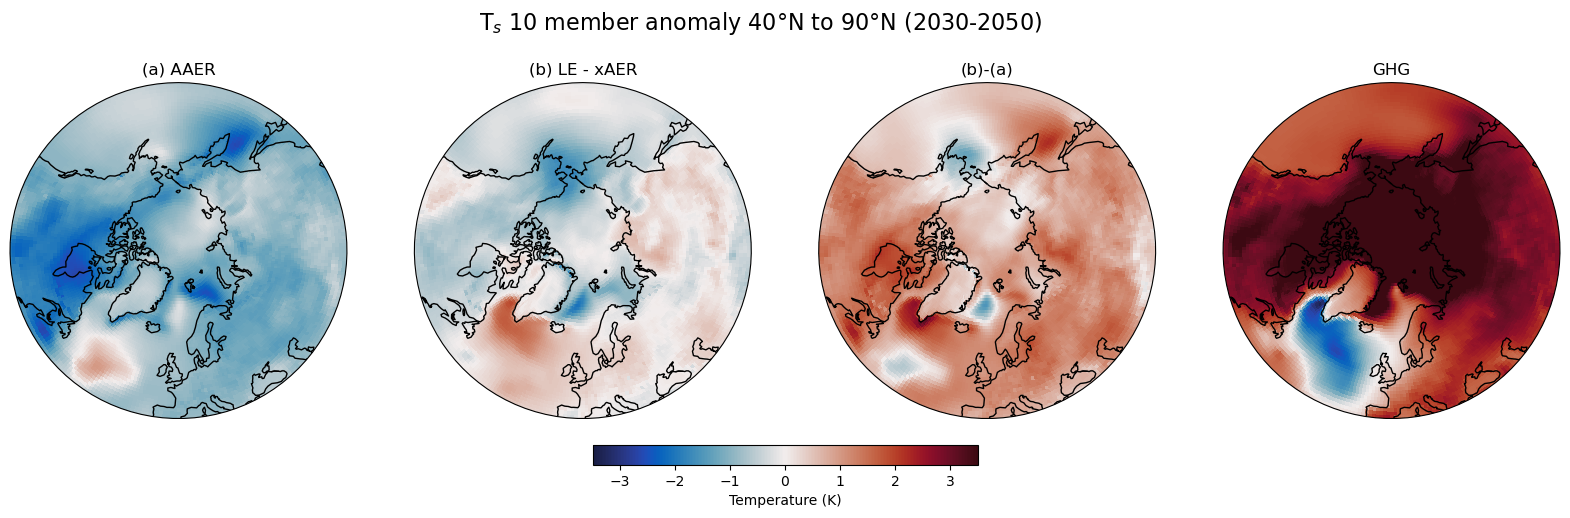

In [7]:
# Load directly
aaer = xr.open_dataset("nonlinear_outputs10/AAER_TREFHT_2030-2050.nc")["TREFHT"]
lexaer = xr.open_dataset("nonlinear_outputs10/LE_minus_xAER_TREFHT_2030-2050.nc")["TREFHT"]
nonlinear = xr.open_dataset("nonlinear_outputs10/Nonlinear_TREFHT_2030-2050.nc")["TREFHT"]
ghg = xr.open_dataset("nonlinear_outputs10/GHG_TREFHT_2030-2050.nc")["TREFHT"]

### FOR PSL ONLY

#aaer = aaer/100
#lexaer = lexaer/100
#nonlinear = nonlinear/100
#ghg = ghg/100

# Plot

plot_global_maps(
    [aaer, lexaer, nonlinear, ghg],
    titles=["(a) AAER", "(b) LE - xAER", "(b)-(a)", "GHG"],
    suptitle = "T$_{s}$ 10 member anomaly $40\degree$N to $90\degree$N (2030-2050)",
    cmap=cmocean.cm.balance,
    vmax=3.5,
    vmin=-3.5
)
plt.savefig("TREFHT/2030-2050(10).png", bbox_inches="tight")